In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm, trange
import tensorflow as tf 
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,GRU
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
    
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
#%cd /content/drive/My-Drive/
# 在線GPU性能检验
!nvidia-smi 
raw = pd.read_csv('/content/gdrive/MyDrive/科技部計畫/data/變數預測股價/DayForMonth.csv',index_col=[0],parse_dates=["Date"])

#read the data
stock = raw 
stock = stock.loc[:,["Close","Average Confirmation Time","Block Height",'Difficulty','Miners Revenue (USD)','Unique Addresses Used','Blockchain Size (MB)','Output Value Per Day','Volume','RPI','TOTRESNS','NONREVSL','SP500','DJIA','NBI','XAUUSD']]
amount = len(stock) 
stock = stock['2017-01-01':'2022-07-30']

stock[1605:]

Mounted at /content/gdrive/
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



,Close,Average Confirmation Time,Block Height,Difficulty,Miners Revenue (USD),Unique Addresses Used,Blockchain Size (MB),Output Value Per Day,Volume,RPI,TOTRESNS,NONREVSL,SP500,DJIA,NBI,XAUUSD
Date,,,,,,,,,,,,,,,,
2021-06-26,37337.53516,323.115730,687456,1.990000e+13,24364896.16,594998,351877.5580,1775215.192,3.858539e+10,17827.219,3848.1,3308.21156,4280.70,34433.84,5121.029785,1780.34
2021-06-27,39406.94141,323.115730,687456,1.990000e+13,24364896.16,379066,351877.5580,1775215.192,3.551164e+10,17827.219,3848.1,3308.21156,4280.70,34433.84,5121.029785,1780.34
2021-06-28,39995.90625,323.115730,687456,1.990000e+13,20581265.56,379066,352241.7256,1775215.192,3.389252e+10,17827.219,3848.1,3308.21156,4290.61,34283.27,5130.990234,1778.18
2021-06-29,40008.42188,168.027805,687456,1.990000e+13,20581265.56,379066,352241.7256,1376609.201,3.790146e+10,17827.219,3848.1,3308.21156,4291.80,34292.29,5129.750000,1761.09
2021-06-30,42235.54688,168.027805,687456,1.990000e+13,20581265.56,567655,352241.7256,1376609.201,3.405904e+10,17827.219,3848.1,3308.21156,4297.50,34502.51,5147.930176,1769.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-26,20260.01953,7.515206,745920,2.770000e+13,21346601.63,629329,745920.0000,1699845.637,2.862467e+10,17703.249,3258.4,3501.68270,3921.05,31761.54,3909.400000,1717.00
2022-07-27,20041.73828,8.727889,745920,2.770000e+13,21346601.63,629329,745920.0000,3749740.111,3.175896e+10,17703.249,3258.4,3501.68270,4023.61,32197.59,3949.900000,1733.89
2022-07-28,19616.81445,8.727889,745920,2.770000e+13,21346601.63,697022,745920.0000,3749740.111,4.021239e+10,17703.249,3258.4,3501.68270,4072.43,32529.63,3927.000000,1755.11


In [ ]:
# lcd[~(lcd['收盤價-除權息'])]
y = stock["Close"]
x = stock
x.shape

(1998, 16)

In [ ]:
#將資料正規化，讓資料變成0~1之間，讓資料訓練速度更快，且更容易收斂

y= y.values.reshape(-1,1) 
scaler=MinMaxScaler(feature_range=(0,1))
scaler1=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(y)
x=scaler1.fit_transform(x)



In [ ]:
#並將資料分成訓練組50，驗證組25，測試組25
#def multivariate_data(dataset, target, start_index, end_index, history_size,
#                      target_size, single_step=False):
x,y=multivariate_data( x ,y , 0 ,None, 1 , 1 ,single_step=True)
i=1605
x_train,y_train  = x[0:int(i)] , y[0:int(i)]
x_vaild,y_vaild  = x[int(i*2/3):int(i)] , y[int(i*2/3):int(i)]
x_test ,y_test   = x[int(i):-1] , y[int(i):-1]


In [ ]:
trainindex= stock.index[10:len(x_train)+10]
valindex = stock.index[len(x_train)+10:len(x_train)+10+len(x_vaild)]

In [ ]:
print(x_train.shape,y_train.shape,x_vaild.shape,y_vaild.shape,x_test.shape ,y_test.shape )

(1605, 1, 16) (1605, 1) (535, 1, 16) (535, 1) (390, 1, 16) (390, 1)


In [ ]:
##GRU
def gru_model(input_length, input_dim):#input_length所選取天數;input_dim所選取特徵數

    d=0.5
    #return_sequences : True 為維持 (batch ,time_steps ,seq_len) ，連接下一層LSTM 設置 False 將會變成一維
    model= Sequential()
    model.add(GRU(128,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    
 
    model.add(Dense(1,activation='linear',kernel_initializer="uniform"))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['mean_squared_error'])
    return model 

In [ ]:
##build GRU model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=70, monitor = 'val_loss')
    ]######## 在訓練組訓練，使用驗證組選取
#EarlyStopping : 在訓練組訓練參數，以驗證組最低為選擇標準，如果300個epochs，沒有改善即停止訓練
filepath="gru.best.hdf5" #模型儲存路徑
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)
#選擇val_loss最低的當作最後的模型
call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
gru = gru_model(1,16)
historygru = gru.fit( x_train, y_train, batch_size=32,shuffle=False , epochs=100,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
#batch 是每次訓練抽取樣本數;epochs 訓練次數;shuffle True 隨機打亂 False 不打亂排序
gru.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
44/51 [========================>.....] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1: val_loss improved from inf to 0.03717, saving model to gru.best.hdf5
51/51 [==============================] - 7s 37ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 2/100
48/51 [===========================>..] - ETA: 0s - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 2: val_loss improved from 0.03717 to 0.02925, saving model to gru.best.hdf5
51/51 [==============================] - 1s 11ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 3/100
45/51 [=========================>....] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 3: val_loss improved from 0.02925 to 0.02084, saving model to gru.best.hdf5
51/51 [==============================] - 1s 11ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0208 - val_mean_squared_error: 

13/13 [==============================] - 0s 2ms/step


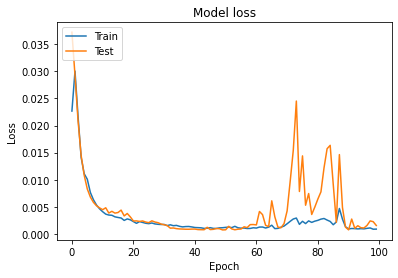

17/17 [==============================] - 0s 2ms/step


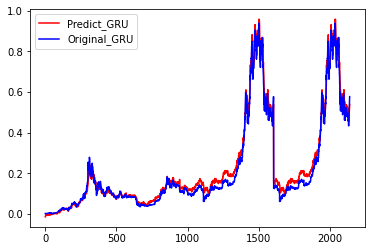

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20729 missing from current font.
  font.set_text(s, 0, flags=flags)


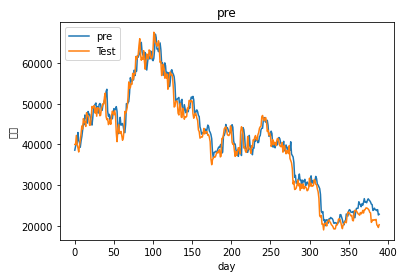

0.9652161946582745

In [ ]:
##GRU model predict performace
gru_train  = gru.predict(x_train)
gru_val = gru.predict(x_vaild)
gru_pre = gru.predict(x_test)
plt.plot(historygru.history['loss'])
plt.plot(historygru.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

pre = gru.predict(x_train)
pre1=gru.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='red', label='Predict_GRU')
pd.Series(yreal.reshape(-1)).plot(color='blue', label='Original_GRU')

plt.legend()
plt.show()

gru_pre= scaler.inverse_transform(gru_pre)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))




plt.figure()
plt.plot(gru_pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('股價')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(gru_pre,y_test) 
from sklearn.metrics import r2_score
r2_score(y_test,gru_pre)

In [ ]:
import pandas as pd
predict = pd.DataFrame(gru_pre)
predict
import os
import time
os.chdir('/content/gdrive/MyDrive/科技部計畫/data')
print(os.getcwd() )#获取当前工作路径
timenow= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
type(timenow) #str

outstr= 'GRUDay'+ timenow + '.csv'
predict.to_csv(outstr) #相对位置，保存在getwcd()获得的路径下

outstr

/content/gdrive/MyDrive/科技部計畫/data


'GRUDay2022-11-16 13:18:02.csv'